In [199]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Нашей задачей является предсказание цены на офис в Москве.

Данные мы взяли с сайта avito.ru.

В данном ноутбуке проводится анализ данных, которые мы выкачали с сайта.

Добавление дополнительных признаков, устранение Nan-ов, сложные визуализации будут дальше.

Здесь проводится первичный анализ и намечаются направления того, как будет в дальнейшем идти работа.

In [57]:
data = pd.read_csv('../final_result.csv')

In [58]:
data.shape

(3243, 9)

In [59]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'size', 'class', 'address', 'price',
       'descr', 'metros', 'url'],
      dtype='object')

Лишние колонки: 'Unnamed: 0', 'Unnamed: 0.1', 'url'.

Нам нужны: площадь в $м^2$, класс, адресс, цена, описание, ближайшие станции метро и расстояние до них.

In [60]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'url'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243 entries, 0 to 3242
Data columns (total 6 columns):
size       3243 non-null float64
class      2022 non-null object
address    3243 non-null object
price      3243 non-null int64
descr      3243 non-null object
metros     3084 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 152.1+ KB


Пропуски есть в метро и в классе

# Класс офиса

In [23]:
data['class'].unique()

array([nan, 'a', 'b', 'c', 'd'], dtype=object)

In [74]:
null_classes = data[data['class'].isnull()]
null_classes.head(5)

,size,class,address,price,descr,metros
0,102.2,NaN,"Россия, Москва, м. Бауманская, Нижняя краснос...",1983,Сдается в аренду ОФИС С ГОТОВЫМ РЕМОНТОМ в зас...,Бауманская (500 м) . Красносельская (600 м)...
2,19.0,NaN,ул Сокольнический Вал 1Д,917,Сдается офисное помещение рядом с метро - 12ми...,Рижская (1.1 км) . Сокольники (1.7 км) . П...
7,105.0,NaN,"Москва, м. Деловой центр, Пресненская набереж...",2476,"Шикарный офис на 62 этаже сдаю в субаренду, ес...",Деловой центр (300 м) . Выставочная (400 м)...
8,20.0,NaN,"ул Смольная, 24А",1020,"Сдаётся в аренду офисное помещение, состоящее ...",Речной вокзал (800 м) . Ховрино (2 км) . В...
10,20.0,NaN,"Колодезный пер.дом 2А,стр.1",667,Аренда от собственника. Сдаются помещения под ...,Преображенская площадь (1.3 км) . Сокольник...


In [83]:
null_classes.iloc[2]['descr']

'Шикарный офис на 62 этаже сдаю в субаренду, есть все: мебель интернет, переговорные, ресепшн, кухня. Красивый вид. '

## Что делать с null-ми в классе?
Думали, что всем у кого нет класса, ставить класс d (раз не указали, значит нечего указывать).

Но присуттсвуют офисы в центре, хорошие по описанию, как выше. Офис на 100 квадратных метров, в центре со всеми удосбствами.

Классы офисов : https://realty.mail.ru/articles/12521/a_b_c_d__klassifikacija_moskovskih_ofisov/

Варианты, что делать (http://www.machinelearning.ru/wiki/images/9/90/Kayumov_course_work_imputer_methods.pdf):
1. Не рассматривать офисы без класса.
2. Не использовать класс как признак.
3. Заменить средним.
4. Изпользовать алгоритмы машинного обучения для заполнения пропущенных значений.

Я (Турганбаев) считаю, что нужно использовать 4-ый вариант.

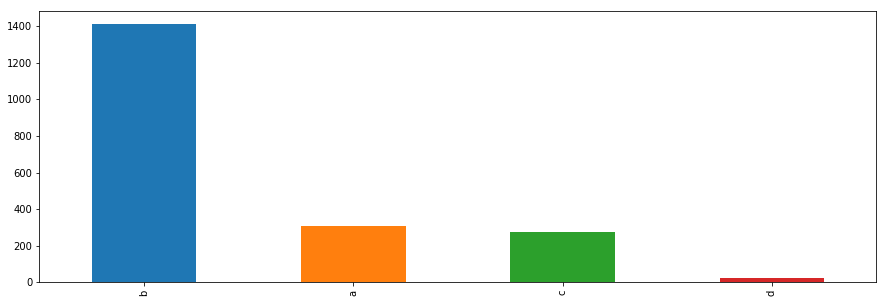

In [85]:
fig = plt.figure(figsize=(15,5))
data['class'].value_counts().plot.bar()

# Цена за $м^2$

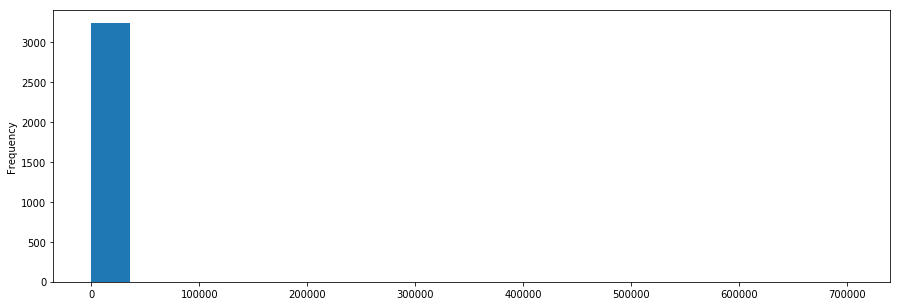

In [233]:
fig = plt.figure(figsize=(15,5))
data['price'].plot.hist(bins = 20)

In [242]:
print("min price =", data['price'].min(),"| max price =", data['price'].max())

min price = 2 | max price = 705100


Похоже есть выбросы по ценам. Есть слишком большие по цене офисы.

Нужно срезать слишком большие цены.

In [312]:
cut_values = [4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]

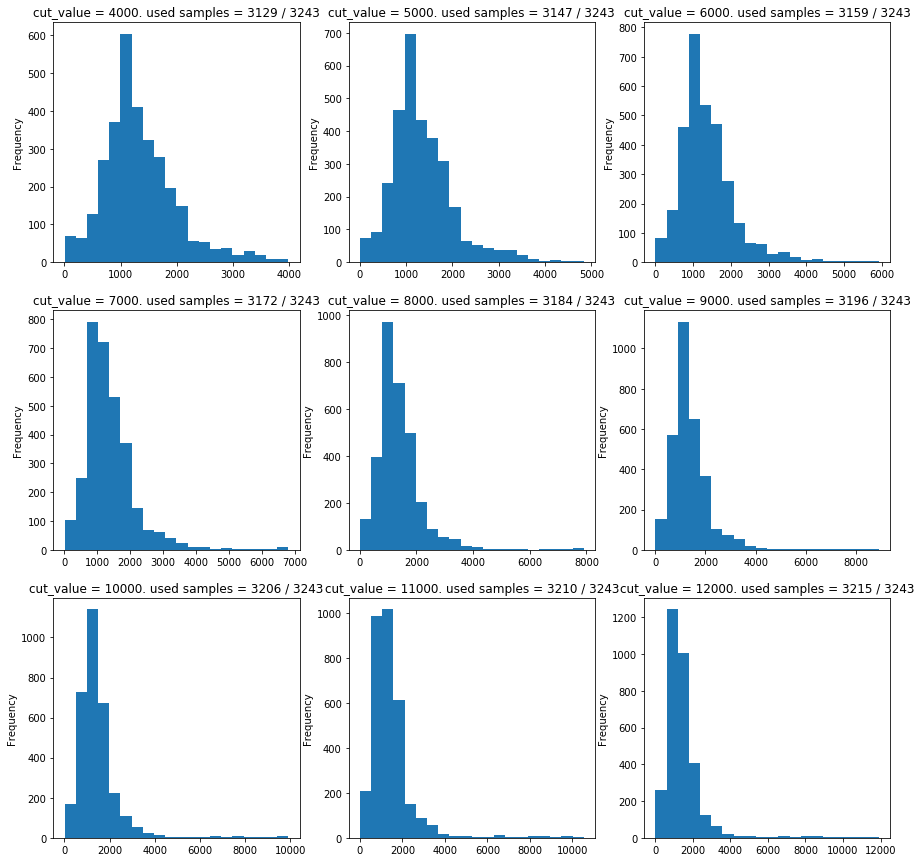

In [313]:
fig, ax = plt.subplots(3,3, figsize = (15, 15))
for cut_value, ax_,  in zip(cut_values, np.ravel(ax)):
    data[data.price < cut_value]['price'].plot.hist(bins = 20, ax=ax_)
    ax_.set_title('cut_value = {0}. used samples = {1} / {2}'.\
                  format(cut_value, data[data.price < cut_value].shape[0], data.shape[0]))

Думаю в качестве cut_value можно взять 4500.

Посмотрим теперь как выглядят цены у дорогих офисов.

In [326]:
PRICE_CUT_VALUE = 4500
print("Таких офисов всего:{0}".format(data[(data.price >= PRICE_CUT_VALUE)].shape[0]))

Таких офисов всего:101


Они распределены так:

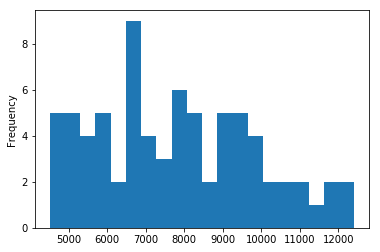

In [359]:
data[(data.price >= PRICE_CUT_VALUE) & (data.price < 13000)]['price'].plot.hist(bins = 20)

In [358]:
data[data.price >= 13000].shape

(26, 6)

Итого с учетом среза гистограмма цены за $м^2$

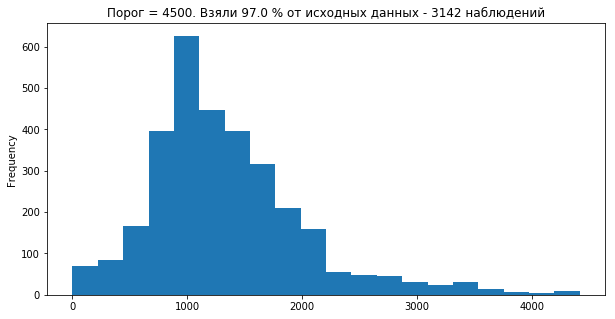

In [392]:
good_prices = data[(data.price < PRICE_CUT_VALUE)]
good_prices['price'].plot.hist(
    bins = 20,
    figsize=(10, 5),
    title="Порог = {0}. Взяли {1} % от исходных данных - {2} наблюдений".format(
        PRICE_CUT_VALUE,
        np.round(good_prices.shape[0] / data.shape[0],2) * 100,
        good_prices.shape[0])
   )


In [446]:
prices_stat = pd.DataFrame(good_prices['price'].describe())
prices_stat

,price
count,3142.000000
mean,1341.535010
std,672.195543
min,2.000000
25%,917.000000
50%,1209.000000
75%,1667.000000
max,4417.000000


# Площадь офиса в $м^2$

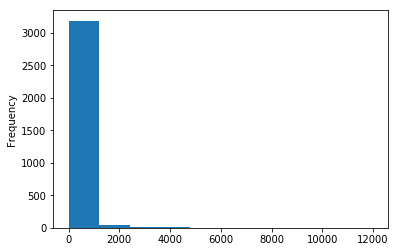

In [375]:
data['size'].plot.hist()

Попробуем выбрать срез

3109 / 3243, 95.87%


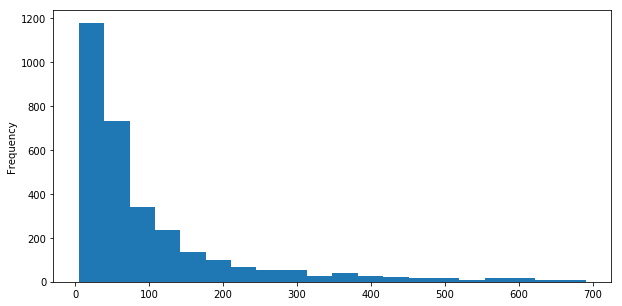

In [473]:
cut_size = 700
print("{0} / {1}, {2}%".format(
        data[data['size'] < cut_size].shape[0],
        data.shape[0],
        np.round(data[data['size'] < cut_size].shape[0] / data.shape[0] * 100, 2))
     )
data[data['size'] < cut_size]['size'].plot.hist(bins = 20, figsize = (10,5))

134 / 3243, 4.04%


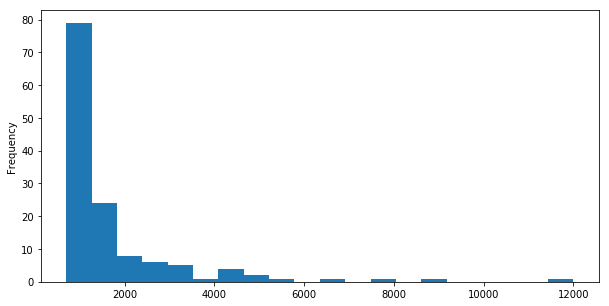

In [407]:
print("{0} / {1}, {2}%".format(
        data[data['size'] >= cut_size].shape[0],
        data.shape[0],
        np.round(data[data['size'] > cut_size].shape[0] / data.shape[0] * 100, 2))
     )
data[data['size'] >= cut_size]['size'].plot.hist(bins = 20, figsize = (10,5))

In [455]:
SIZE_CUT_VALUE = 700
good_sizes = data[data['size'] < cut_size]
sizes_stat = pd.DataFrame(good_sizes['size'].describe())
sizes_stat

,size
count,3109.000000
mean,98.704117
std,118.610135
min,5.000000
25%,25.000000
50%,55.000000
75%,119.400000
max,690.900000


# Связь цены и площади

Теперь когда срезали выбросы, посмотрим на связь цены и площади

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


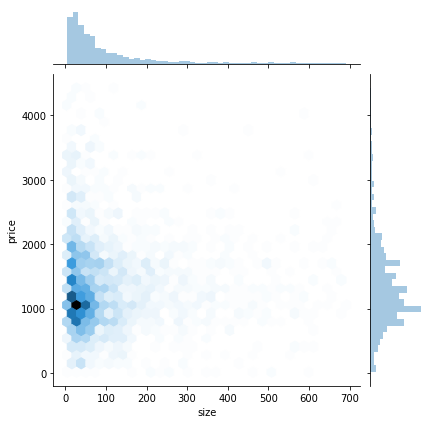

In [561]:
sns.jointplot(x='size', y='price', data=data[(data.price < PRICE_CUT_VALUE) & (data['size'] < SIZE_CUT_VALUE)], kind = 'hex',gridsize=30)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


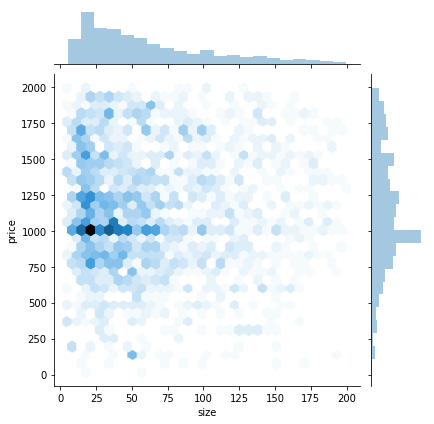

In [560]:
sns.jointplot(x='size', y='price', data=data[(data.price < 2000) & (data['size'] < 200)], kind = 'hex',gridsize=30)

Корреляция между ценой и размером:

In [495]:
data[(data.price < PRICE_CUT_VALUE) & (data['size'] < SIZE_CUT_VALUE)][['size','price']].corr()

,size,price
size,1.000000,0.002507
price,0.002507,1.000000


# Cвязь класса и цены, класса и площади

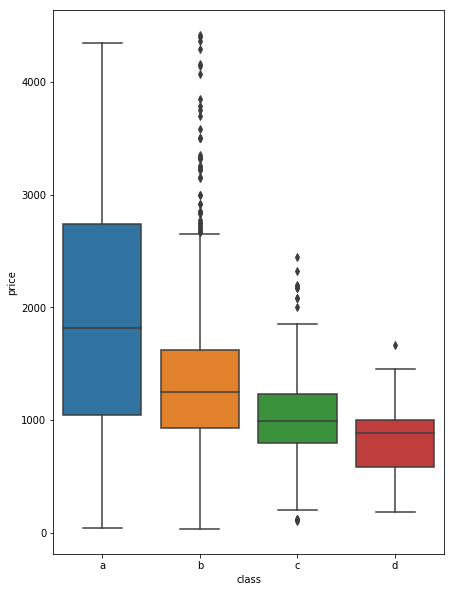

In [510]:
plt.subplots(figsize=(7,10))
sns.boxplot(x='class', y = 'price', data=data[(data.price < PRICE_CUT_VALUE) & (data['size'] < SIZE_CUT_VALUE)])

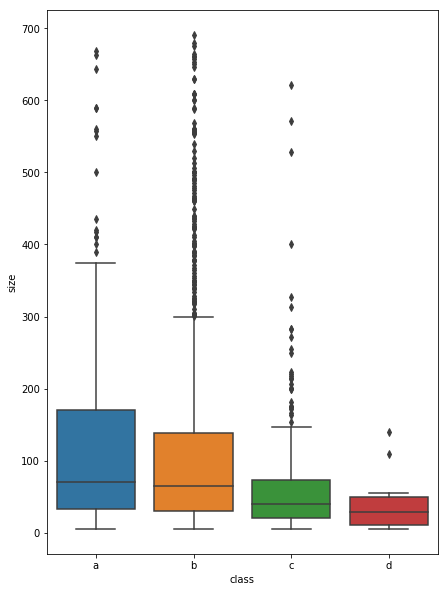

In [514]:
plt.subplots(figsize=(7,10))
sns.boxplot(x='class', y = 'size', data=data[(data.price < PRICE_CUT_VALUE) & (data['size'] < SIZE_CUT_VALUE)])

# Cоотношение цены и площади в зависимости от класса.

In [550]:
good_data = data[(data.price < PRICE_CUT_VALUE) & (data['size'] < SIZE_CUT_VALUE)]
classes = ['a', 'b', 'c', 'd']
for class_ in classes:
    print("Класс {2} занимает от отфильрованного датасета {0} / {1}".\
          format(good_data[good_data['class']== class_].shape[0],
                 good_data[~good_data['class'].isnull()].shape[0], class_))

Класс a занимает от отфильрованного датасета 237 / 1847
Класс b занимает от отфильрованного датасета 1319 / 1847
Класс c занимает от отфильрованного датасета 269 / 1847
Класс d занимает от отфильрованного датасета 22 / 1847


Можно предположить, что многие из класса D не имеют класса в наблюдениях.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Класс B')

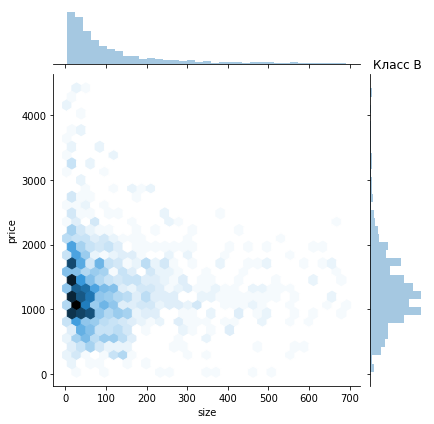

In [559]:
sns.jointplot(x='size', y='price', data=good_data[good_data['class']== 'b'], kind = 'hex',gridsize=30)
plt.title('Класс B')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Класс А')

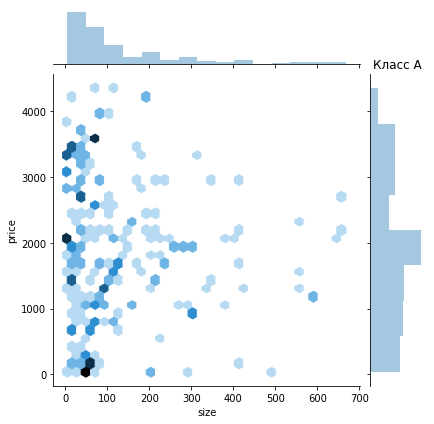

In [569]:
sns.jointplot(x='size', y='price', data=good_data[good_data['class']== 'a'], kind = 'hex',gridsize=30)
plt.title('Класс А')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Класс С')

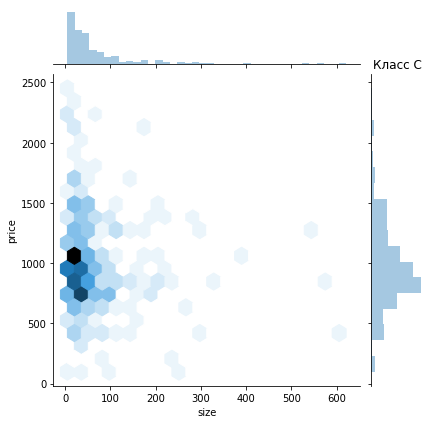

In [570]:
sns.jointplot(x='size', y='price', data=good_data[good_data['class']== 'c'], kind = 'hex',gridsize=20)
plt.title('Класс С')

# Описание из объявления
Описание содержит подробную информацию о датасете в текстовом виде. Из описания можно достать дополнительные признаки.

Получаем задачу Text Mining-a.

In [575]:
data['descr']

0       Сдается в аренду ОФИС С ГОТОВЫМ РЕМОНТОМ в зас...
1       Сдается на длительный срок офисное помещение в...
2       Сдается офисное помещение рядом с метро - 12ми...
3       Сдаются в аренду офисы категории B+           ...
4       Сдается офис 165 м2 на востоке Москвы. Помещен...
5       Офис 110 кв м, на выходе из ремонта. Кабинетна...
6       Сдается отдельный офис 14 кв.м. с мебелью и бе...
7       Шикарный офис на 62 этаже сдаю в субаренду, ес...
8       Сдаётся в аренду офисное помещение, состоящее ...
9       Офисное помещение в аренду от собственника 104...
10      Аренда от собственника. Сдаются помещения под ...
11      Помещение в аренду площадью 32.2 кв.м., распол...
12      Аренда офисного помещения, 23,03 кв.м. от собс...
13        Отличное предложение! Сдается под офис целый...
14        БЦ «Саммит» («Summit») является качественным...
15        БЦ «Саммит» («Summit») является качественным...
16        БЦ «Саммит» («Summit») является качественным...
17        В БЦ

# Адрес

Из адреса можно получить широту и долготу здания, где находится офис.

Затем можно получать данные об инфраструктуре вокруг объекта. Это позволит достать дополнительные признаки.

Предлагаю воспользоваться этим:
https://tech.yandex.ru/maps/doc/geosearch/concepts/about-docpage/



# Расстояния до метро

Аналогично перевести в широту и долготу. Получить дополнительную информацию об инфраструктуре вокруг метро.
В случае пропусков можно также через api найти ближайшее метро.

# Итоги:
1. В признаке класс большое колчисество пропусков, необходимо каким-то образом их заполнить.
2. Удалось отфильтровать датасет по цене и размеру. Гистограммы цены и площади имеют "хорошую" форму.
3. В объявлениях содержатся признаки, которые можно использовать. Необходимо решать задачу Text Mining-а.
4. Можно получить дополнительную информацию из адреса и метро с помощью сторонних api.